# Dataset Information
- Competition: https://www.kaggle.com/competitions/playground-series-s4e2/overview
- Origin Dataset: https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster
- Interesting: https://rstudio-pubs-static.s3.amazonaws.com/872760_24a044829eda4ba68996628b3a9efb06.html


- FAVC - Frequent consumption of high caloric food
- FCVC - Frequency of consumption of vegetables
- NCP - Number of main meals
- CAEC - Consumption of food between meals
- CH20 - Consumption of water daily
- SCC - Calories consumption monitoring
- FAF - Physical activity frequency
- TUE - Time using technology devices 
- CALC - Consumption of alcohol
- MTRANS - Transportation used    


NObesity values are:
- Insufficient_Weight Less than 18.5
- Normal_Weight 18.5 to 24.9
- Overweight_Level_I 25.0 to 29.9
- Overweight_Level_II I 30.0 to 34.9
- Obesity_Type_I II 35.0 to 39.9
- Obesity_Type_II more than 40

# Goal of the  of this competition
To use various factors to predict obesity risk in individuals, which is related to cardiovascular disease. Good luck!

# Submission Goal
Estimate NObeyesdad for every id.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder ,OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_selector

In [83]:
# Load the data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_submission = pd.read_csv("sample_submission.csv")
# Load data from other dataset 
df_obesity = pd.read_csv("ObesityDataSet.csv") # Original data 
#df_train = pd.concat([df_train, df_obesity], axis =0)  # axis = 0 , needed for function concat, connect theses dataframes vertically together
#df_train = df_train.drop_duplicates()
#display(df_train.shape, df_train.head(), df_train.describe(include=[np.number]).T, df_train.describe(include=[object]).T, df_train.isna().sum())

First thoughts about the dataset:
- Age is Min 14 years old and max is 61
- Sex is Male and Female
- Height 145cm - 197 cm
- Weight 39kg - 165kg

In [84]:
df_obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [85]:
df_obesity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [86]:
pd.set_option('display.max_columns', None)
df_train.head(50)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
5,5,Male,18.128249,1.748524,51.552595,yes,yes,2.919751,3.000000,Sometimes,no,2.137550,no,1.930033,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
6,6,Male,29.883021,1.754711,112.725005,yes,yes,1.991240,3.000000,Sometimes,no,2.000000,no,0.000000,0.696948,Sometimes,Automobile,Obesity_Type_II
7,7,Male,29.891473,1.750150,118.206565,yes,yes,1.397468,3.000000,Sometimes,no,2.000000,no,0.598655,0.000000,Sometimes,Automobile,Obesity_Type_II
8,8,Male,17.000000,1.700000,70.000000,no,yes,2.000000,3.000000,Sometimes,no,3.000000,yes,1.000000,1.000000,no,Public_Transportation,Overweight_Level_I
9,9,Female,26.000000,1.638836,111.275646,yes,yes,3.000000,3.000000,Sometimes,no,2.632253,no,0.000000,0.218645,Sometimes,Public_Transportation,Obesity_Type_III


In [87]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [88]:
# delete id column
df_train = df_train.drop(['id'], axis=1)
# Merge dataframes together
merge = [df_train, df_obesity]
df_train = pd.concat(merge)
# Convert to obj to category type
df_train[['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']] = df_train[['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']].astype('category')
# copy of the original
df_original = df_train

In [89]:
df_original.info

<bound method DataFrame.info of       Gender        Age    Height      Weight family_history_with_overweight  \
0       Male  24.443011  1.699998   81.669950                            yes   
1     Female  18.000000  1.560000   57.000000                            yes   
2     Female  18.000000  1.711460   50.165754                            yes   
3     Female  20.952737  1.710730  131.274851                            yes   
4       Male  31.641081  1.914186   93.798055                            yes   
...      ...        ...       ...         ...                            ...   
2106  Female  20.976842  1.710730  131.408528                            yes   
2107  Female  21.982942  1.748584  133.742943                            yes   
2108  Female  22.524036  1.752206  133.689352                            yes   
2109  Female  24.361936  1.739450  133.346641                            yes   
2110  Female  23.664709  1.738836  133.472641                            yes   

     FA

In [90]:
df_train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [91]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22869 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          22869 non-null  category
 1   Age                             22869 non-null  float64 
 2   Height                          22869 non-null  float64 
 3   Weight                          22869 non-null  float64 
 4   family_history_with_overweight  22869 non-null  category
 5   FAVC                            22869 non-null  category
 6   FCVC                            22869 non-null  float64 
 7   NCP                             22869 non-null  float64 
 8   CAEC                            22869 non-null  category
 9   SMOKE                           22869 non-null  category
 10  CH2O                            22869 non-null  float64 
 11  SCC                             22869 non-null  category
 12  FAF                     

In [92]:
df_train.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000
mean,23.885263,1.700377,87.767610,2.443428,2.754344,2.027442,0.984382,0.620551
std,5.753419,0.087881,26.364243,0.533329,0.712711,0.608901,0.839466,0.602850
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631662,66.000000,2.000000,3.000000,1.755907,0.015860,0.000000
50%,22.815416,1.700000,84.000000,2.392665,3.000000,2.000000,1.000000,0.579541
75%,26.000000,1.763029,111.531208,3.000000,3.000000,2.535127,1.596576,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


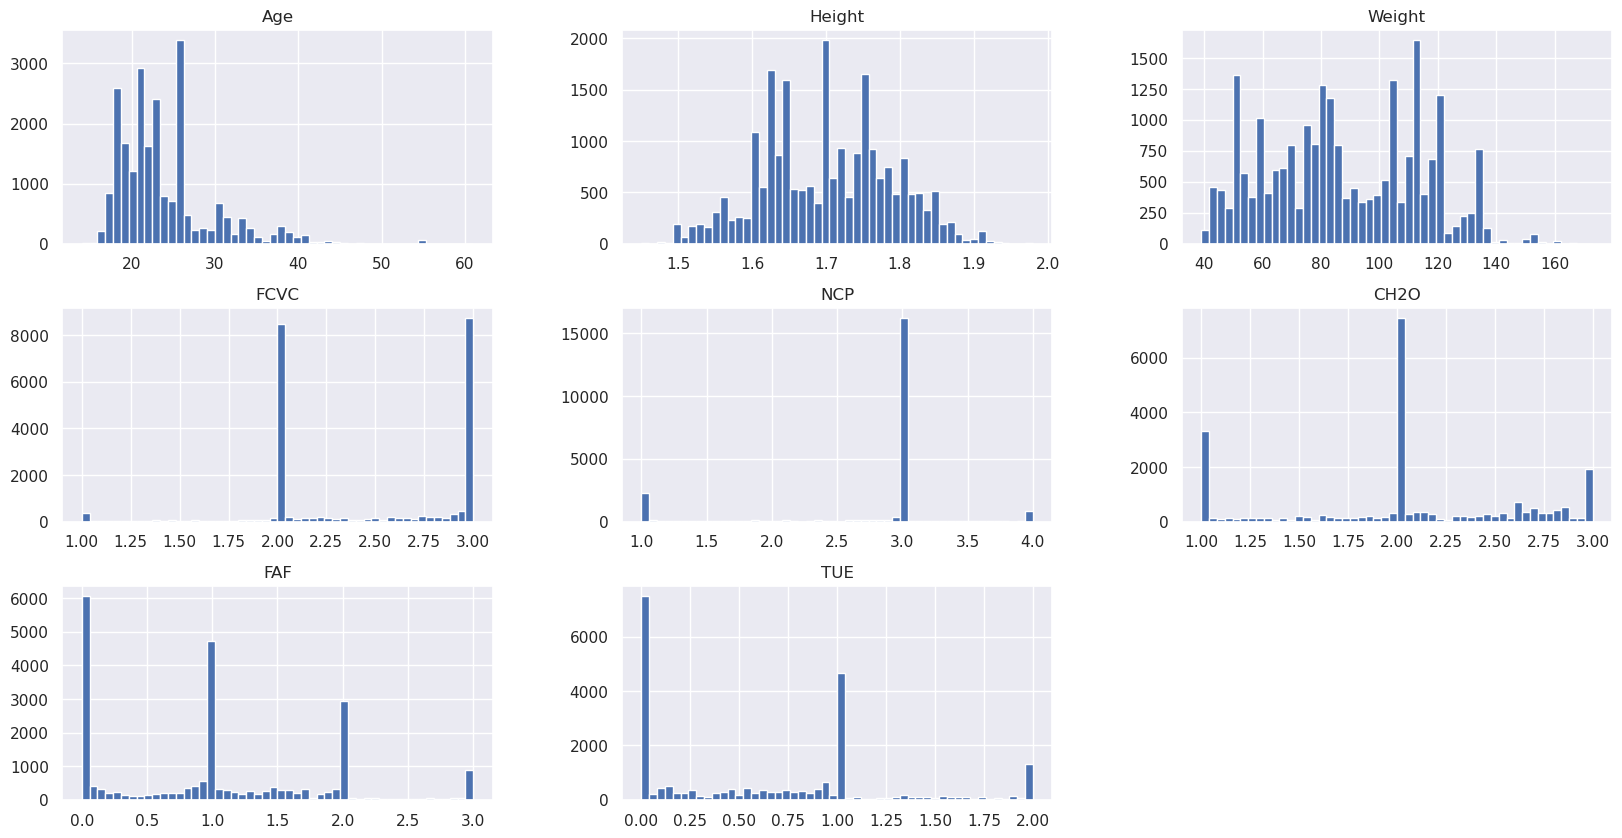

In [93]:
df_train.hist(bins=50, figsize=(20,10))
plt.rcParams.update({'font.size': 20})
plt.show()

Feature Age could be scaled because of the slight left shift.

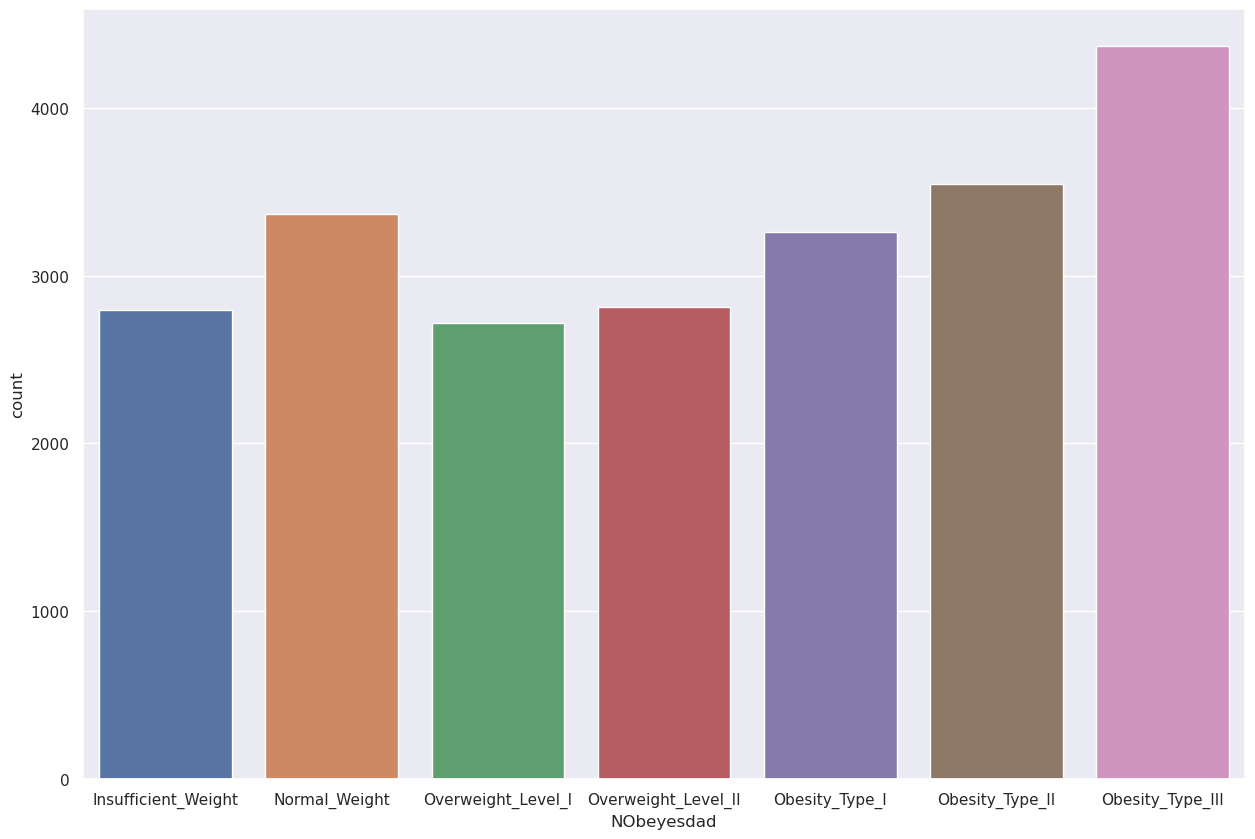

In [94]:
sns.set(font_scale=1)
plt.figure(figsize=(15, 10))
NObeyesdad_order= ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II' ,'Obesity_Type_III'] 
sns.countplot(data = df_train, x='NObeyesdad',order= NObeyesdad_order ) # There are not all even.
plt.show()

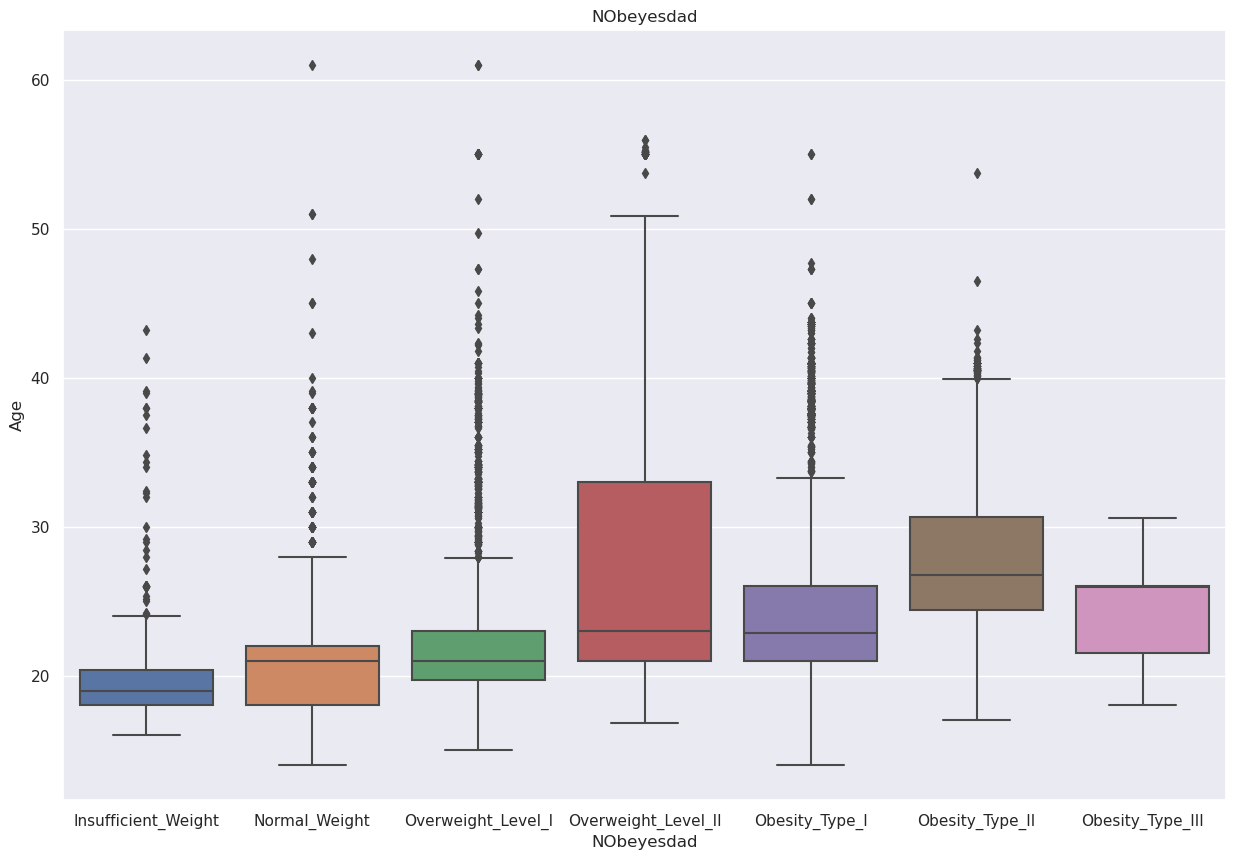

In [95]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.boxplot(data = df_train, y="Age", x="NObeyesdad", order=NObeyesdad_order)
plt.title("NObeyesdad")
plt.show()

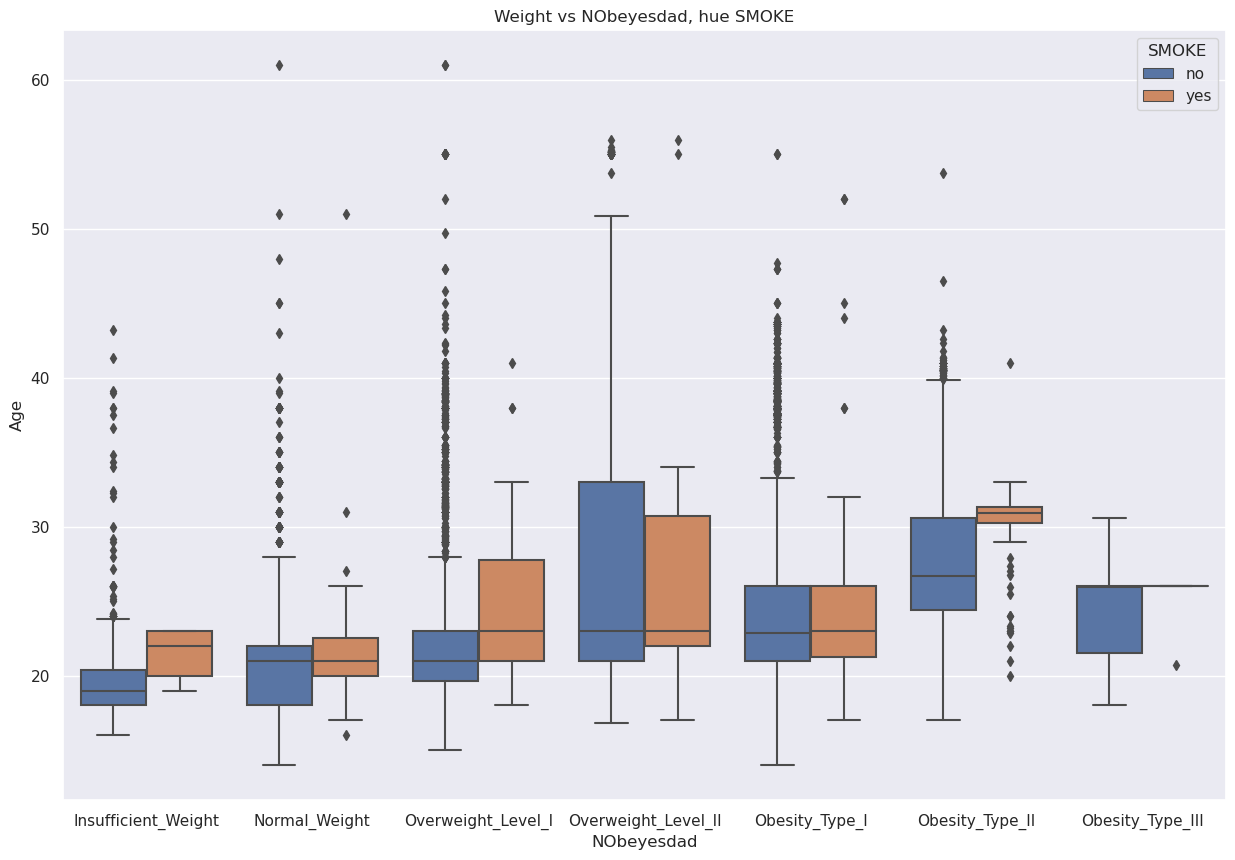

In [96]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.boxplot(data = df_train, y="Age", x="NObeyesdad", hue="SMOKE", order=NObeyesdad_order)
plt.title("Weight vs NObeyesdad, hue SMOKE")
plt.show()

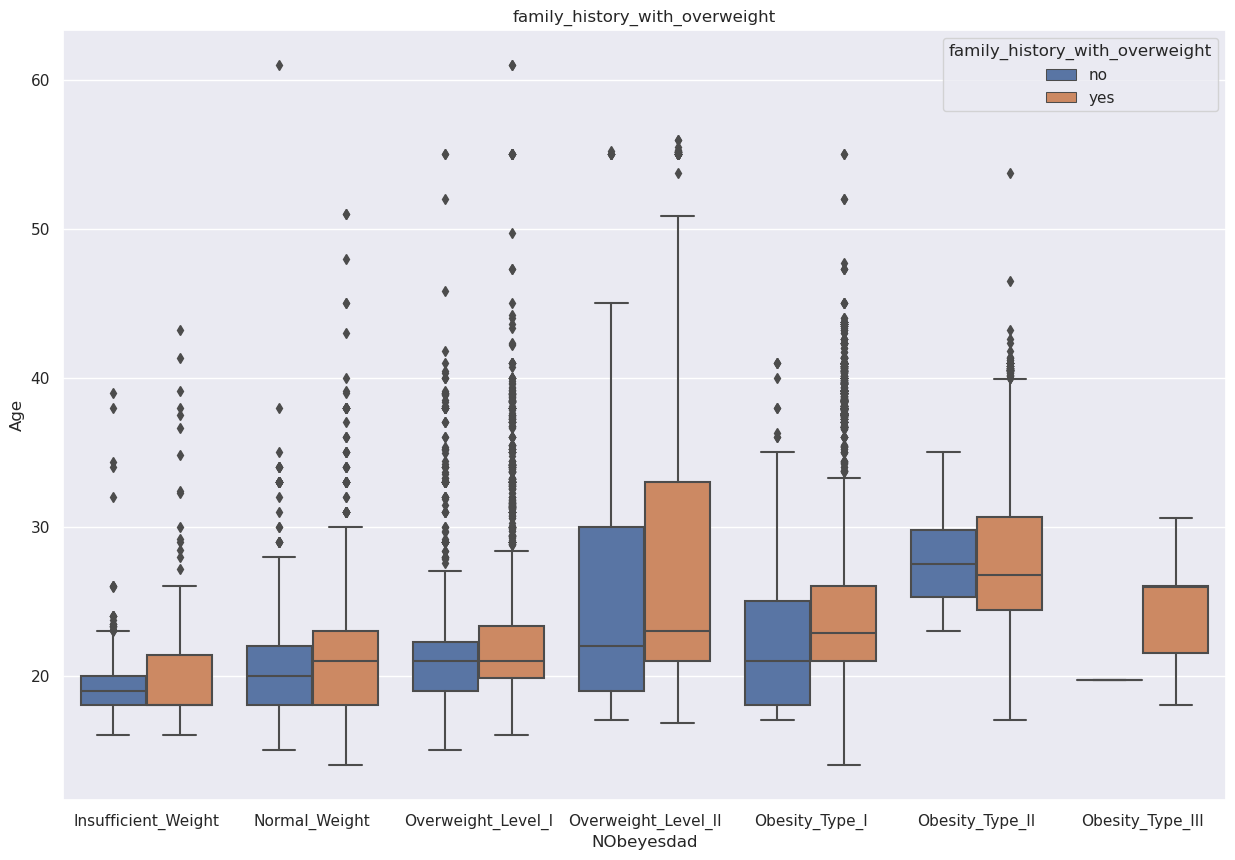

In [97]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.boxplot(data = df_train, y="Age", x="NObeyesdad", hue="family_history_with_overweight", order=NObeyesdad_order)
plt.title("family_history_with_overweight")
plt.show()

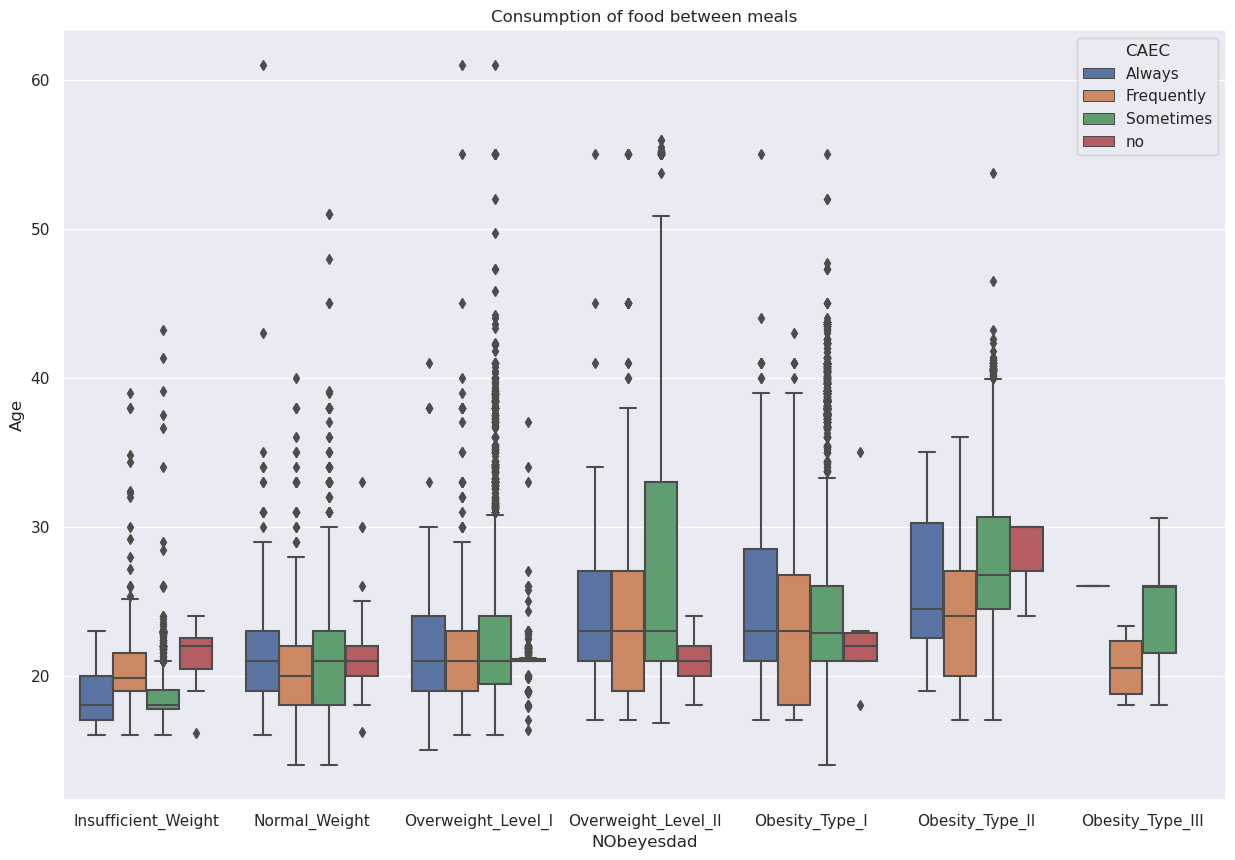

In [98]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.boxplot(data = df_train, y="Age", x="NObeyesdad", hue="CAEC", order=NObeyesdad_order)
plt.title("Consumption of food between meals")
plt.show()

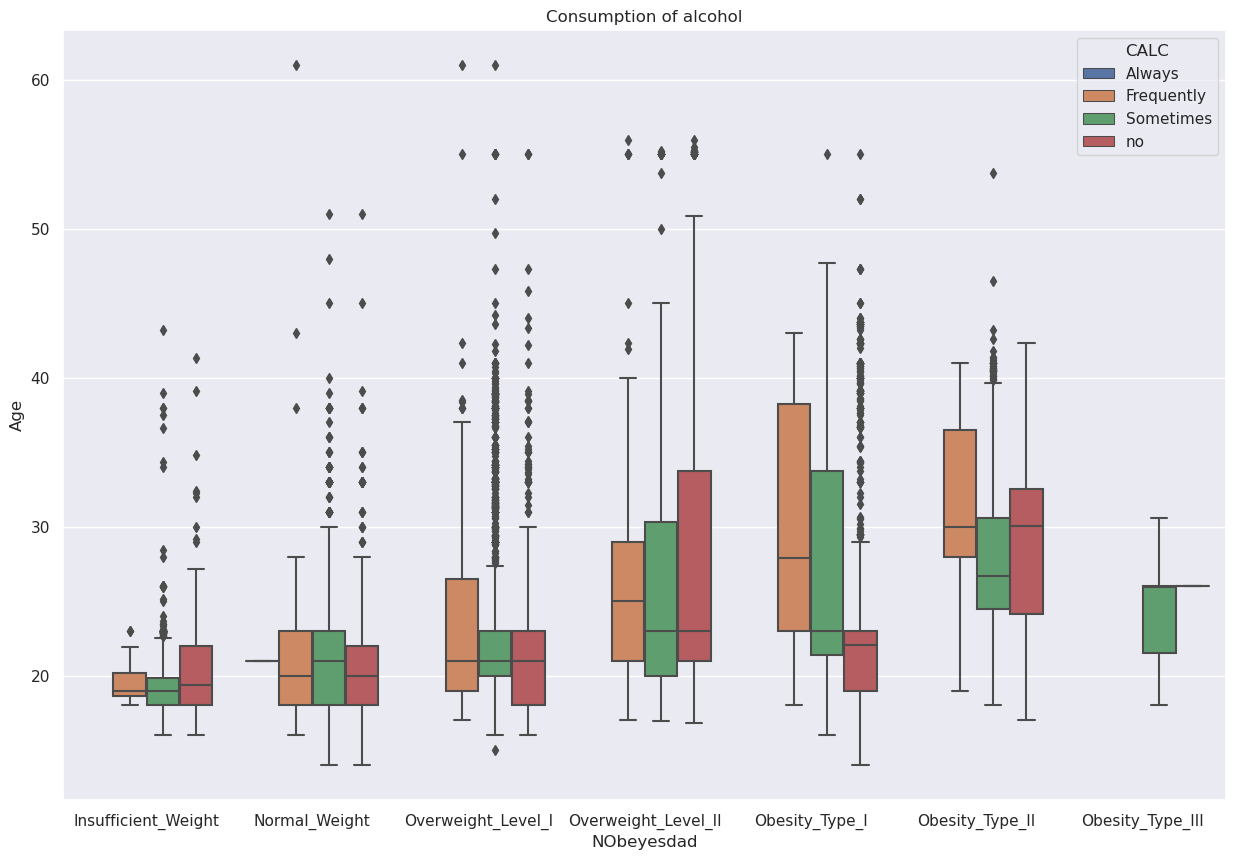

In [99]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.boxplot(data = df_train, y="Age", x="NObeyesdad", hue="CALC", order=NObeyesdad_order)
plt.title("Consumption of alcohol")
plt.show()

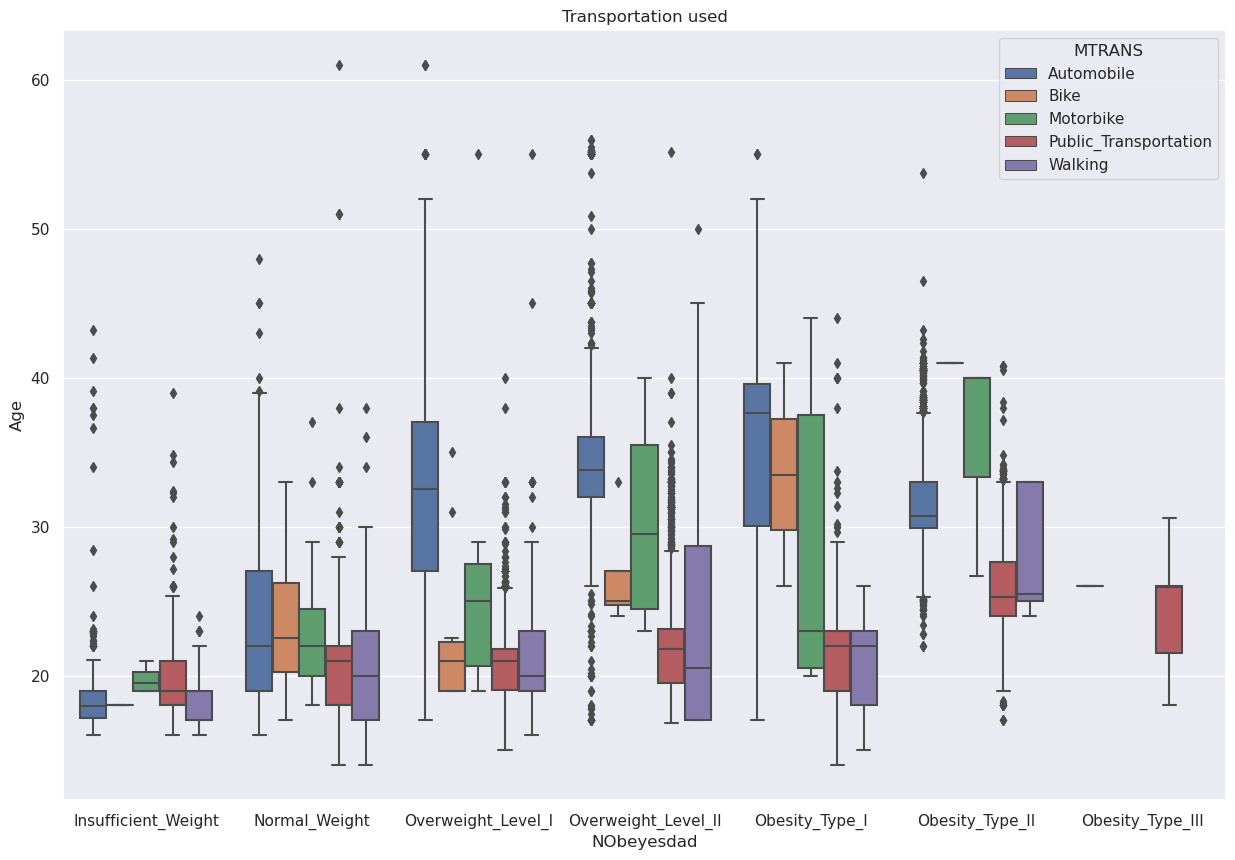

In [100]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.boxplot(data = df_train, y="Age", x="NObeyesdad", hue="MTRANS", order=NObeyesdad_order)
plt.title("Transportation used")
plt.show()

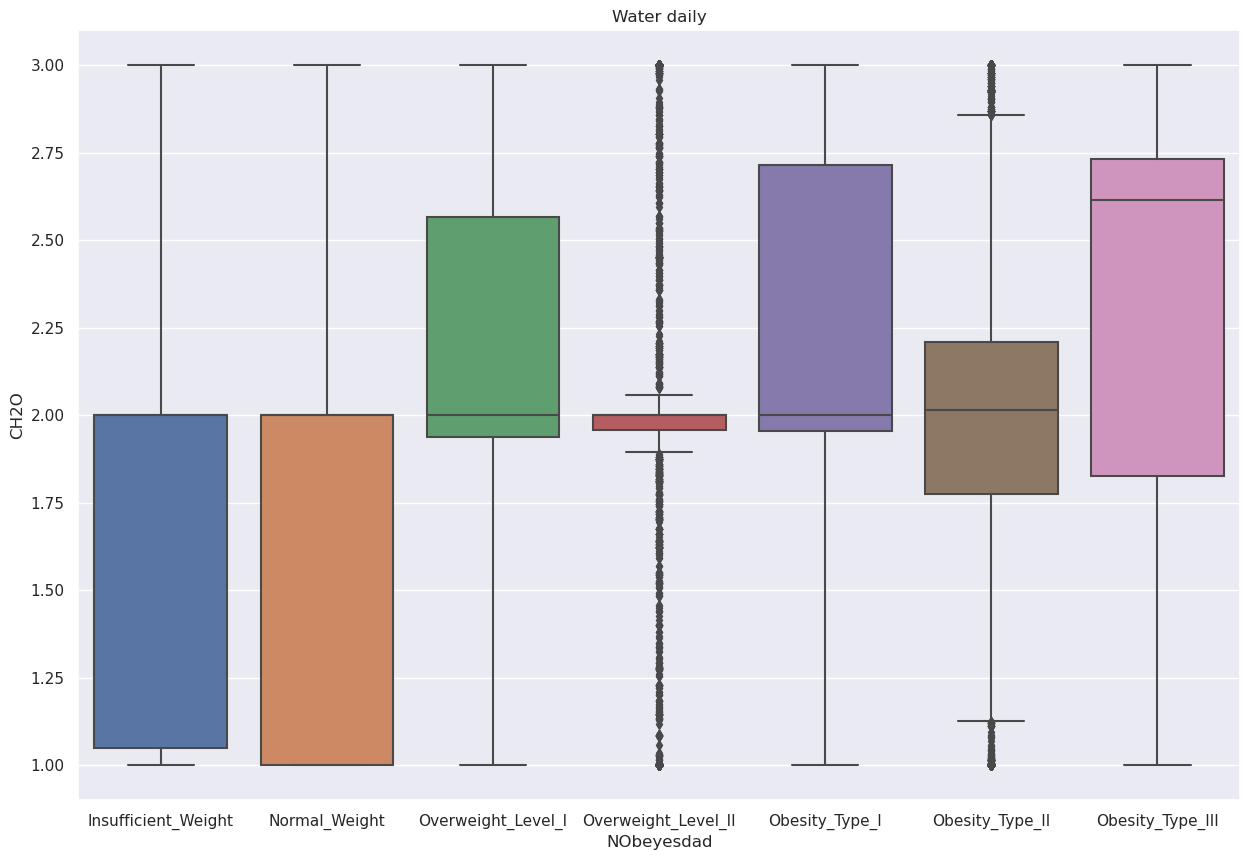

In [101]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.boxplot(data = df_train, y="CH2O", x="NObeyesdad", order=NObeyesdad_order)
plt.title("Water daily")
plt.show()


# Corr Matrix

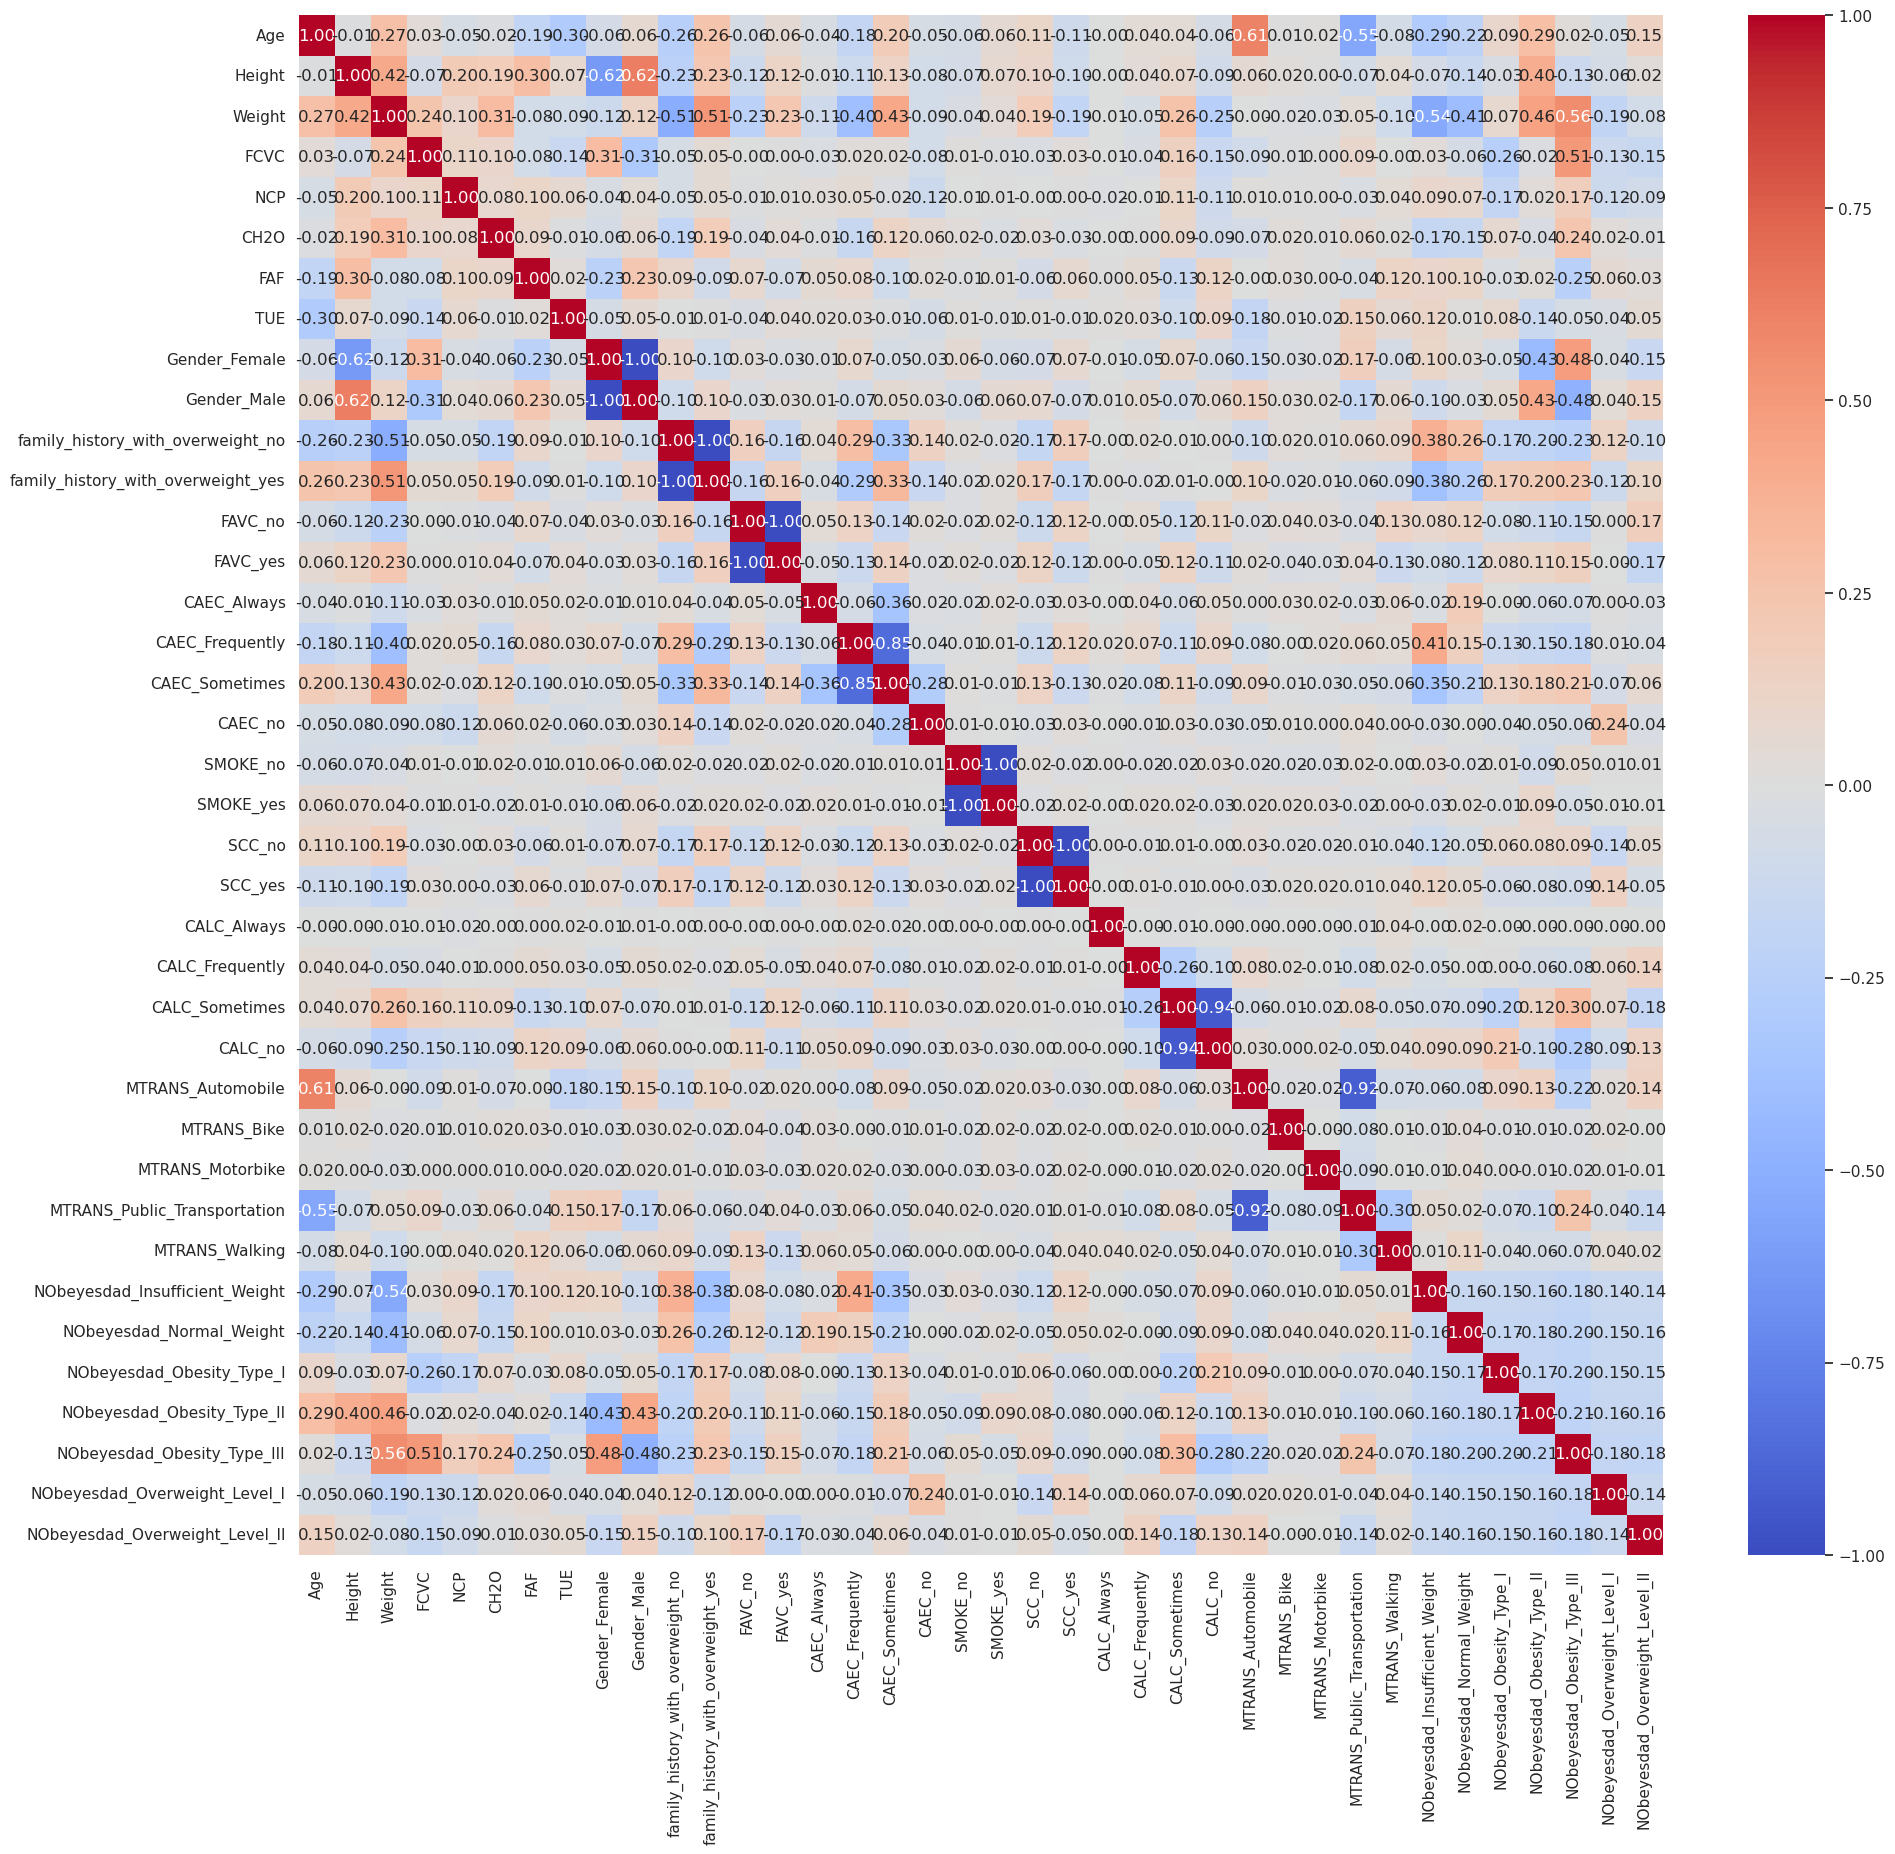

In [103]:
# big correlation matrix 
df_with_dummies = pd.get_dummies(df_train, columns=['Gender','family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad'])
corr_with_dummies =  df_with_dummies.corr()
plt.figure(figsize=(22 , 20))
sns.heatmap(corr_with_dummies, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Data Cleaning

In [ ]:
df_train.isnull().sum() # no missing values

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [ ]:
df_train.drop_duplicates(keep='first', inplace=True)

In [ ]:
df_train.info

<bound method DataFrame.info of       Gender        Age    Height      Weight family_history_with_overweight  \
0       Male  24.443011  1.699998   81.669950                            yes   
1     Female  18.000000  1.560000   57.000000                            yes   
2     Female  18.000000  1.711460   50.165754                            yes   
3     Female  20.952737  1.710730  131.274851                            yes   
4       Male  31.641081  1.914186   93.798055                            yes   
...      ...        ...       ...         ...                            ...   
2106  Female  20.976842  1.710730  131.408528                            yes   
2107  Female  21.982942  1.748584  133.742943                            yes   
2108  Female  22.524036  1.752206  133.689352                            yes   
2109  Female  24.361936  1.739450  133.346641                            yes   
2110  Female  23.664709  1.738836  133.472641                            yes   

     FA

# Preprocessing

In [ ]:
X_train, y_train = df_train.drop("NObeyesdad", axis=1), df_train["NObeyesdad"]
X_test = df_test

# Model selection

In [ ]:
# Defining column names for categorical and numerical features
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC']
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Splitting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining pipelines for transformations
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Combining pipelines with ColumnTransformer
preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_features),
    ('num', numerical_pipeline, numerical_features)
])


In [ ]:
# Building the entire pipeline for Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
}

# GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=2, n_jobs=-1)

# Training the Random Forest model with cross-validation
rf_grid_search.fit(X_train, y_train)

# Best parameters and best accuracy for Random Forest
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best accuracy for Random Forest:", rf_grid_search.best_score_)

# Predictions for the test dataset using Random Forest
rf_predictions = rf_grid_search.predict(X_test)

# Outputting the predictions for Random Forest
print("Random Forest predictions:", rf_predictions)

# Cross-validation predictions for RF
rf_predictions_cv = cross_val_predict(rf_grid_search.best_estimator_, X_train, y_train, cv=3)

# Outputting the predictions for Random Forest
print("RF predictions (Cross-Validation):", rf_predictions_cv)

# Error analysis for RF based on Cross-Validation
print("\nError analysis for RF (Cross-Validation):")
print(classification_report(y_train, rf_predictions_cv))

# Confusion Matrix for RF based on Cross-Validation
conf_matrix_cv = confusion_matrix(y_train, rf_predictions_cv)

# Outputting the Confusion Matrix
print("\nConfusion Matrix for RF (Cross-Validation):")
print(conf_matrix_cv)

Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__n_estimators': 300}
Best accuracy for Random Forest: 0.8951633751606245
Random Forest predictions: ['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_II']
RF predictions (Cross-Validation): ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight' ...
 'Obesity_Type_III' 'Obesity_Type_III' 'Obesity_Type_III']

Error analysis for RF (Cross-Validation):
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.92      0.93      2790
      Normal_Weight       0.83      0.89      0.86      3364
     Obesity_Type_I       0.90      0.88      0.89      3261
    Obesity_Type_II       0.97      0.97      0.97      3545
   Obesity_Type_III       1.00      1.00      1.00      4370
 Overweight_Level_I       0.80      0.72      0.76      2703
Overweight_Level_II       0.78      0.82      0.80      2812

        


Best parameters for XGBoost: {'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.9}
Best accuracy for XGBoost: 0.9093458291831293
XGBoost predictions (Cross-Validation): ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight' ...
 'Obesity_Type_III' 'Obesity_Type_III' 'Obesity_Type_III']

Error analysis for XGBoost (Cross-Validation):
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.94      0.94      2790
      Normal_Weight       0.88      0.90      0.89      3364
     Obesity_Type_I       0.90      0.89      0.90      3261
    Obesity_Type_II       0.97      0.97      0.97      3545
   Obesity_Type_III       1.00      1.00      1.00      4370
 Overweight_Level_I       0.83      0.79      0.81      2703
Overweight_Level_II       0.82      0.84      0.83      2812

           accuracy                           0.91     22

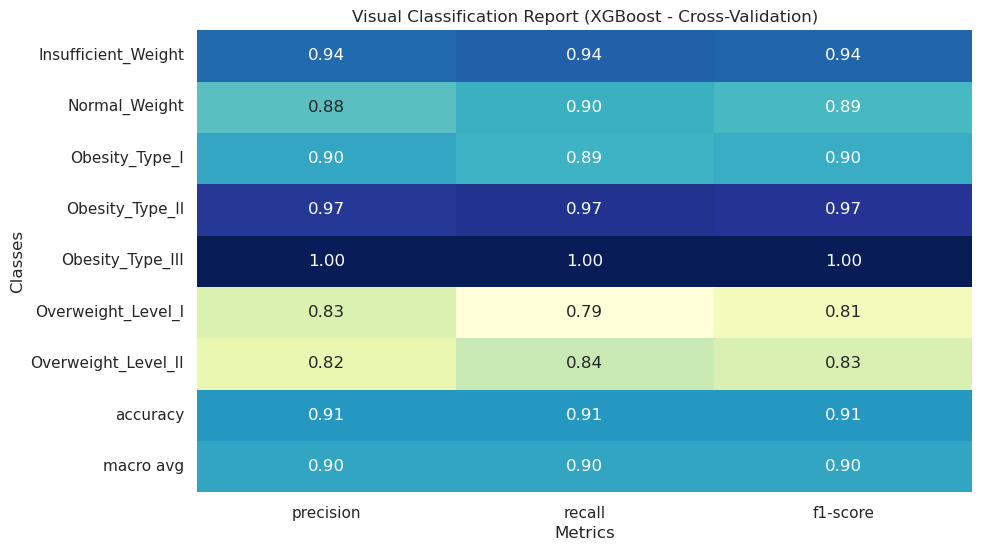

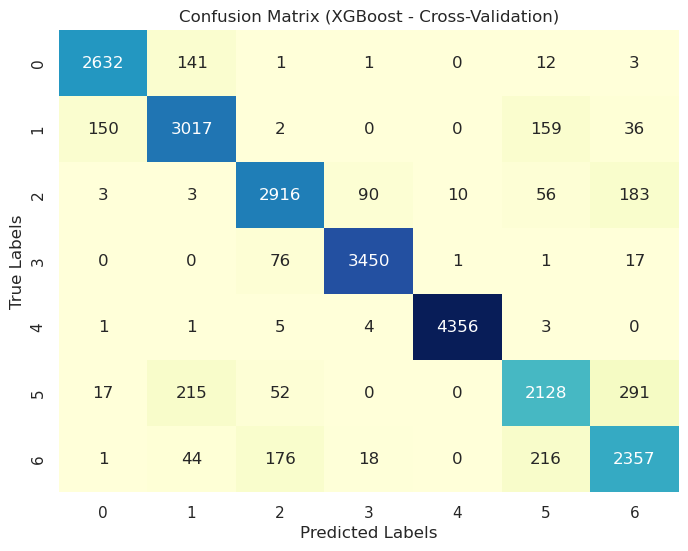

In [ ]:
# Encoding class labels for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Building the entire pipeline for XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier())
])

# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'classifier__n_estimators': [800, 900, 1000],
    'classifier__max_depth': [4],
    'classifier__learning_rate': [0.05, 0.1],  # Adding learning rates
    'classifier__subsample': [0.8, 0.9],  # Sampling size for bootstrapping
    'classifier__colsample_bytree': [0.5, 0.6]  # Feature subsampling rate per tree
}

# GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=2, n_jobs=-1)

# Training the XGBoost model with cross-validation
xgb_grid_search.fit(X_train, y_train_encoded)

# Best parameters and best accuracy for XGBoost
print("\nBest parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best accuracy for XGBoost:", xgb_grid_search.best_score_)

# Cross-validation predictions for XGBoost
xgb_predictions_encoded_cv = cross_val_predict(xgb_grid_search.best_estimator_, X_train, y_train_encoded, cv=5)

# Decoding the predictions for XGBoost
xgb_predictions_cv = label_encoder.inverse_transform(xgb_predictions_encoded_cv)

# Outputting the predictions for XGBoost
print("XGBoost predictions (Cross-Validation):", xgb_predictions_cv)

# Error analysis for XGBoost based on Cross-Validation
print("\nError analysis for XGBoost (Cross-Validation):")
print(classification_report(y_train, xgb_predictions_cv))

# Confusion Matrix for XGBoost based on Cross-Validation
conf_matrix_cv = confusion_matrix(y_train, xgb_predictions_cv)

# Outputting the Confusion Matrix
print("\nConfusion Matrix for XGBoost (Cross-Validation):")
print(conf_matrix_cv)

# Plotting the Classification Report
df_report = pd.DataFrame(classification_report(y_train, xgb_predictions_cv, output_dict=True)).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f", cbar=False)
plt.title('Visual Classification Report (XGBoost - Cross-Validation)')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cv, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix (XGBoost - Cross-Validation)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Predictions for the test dataset with XGBoost
prediction_X_test_encoded = xgb_grid_search.predict(X_test)
prediction_X_test = label_encoder.inverse_transform(prediction_X_test_encoded)

print (prediction_X_test) 
df_submission['NObeyesdad'] = prediction_X_test
df_submission.to_csv('submission.csv', index=False)

['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_II']
